In [1]:
import prior
dataset = prior.load_dataset("procthor-10k")

house = dataset["train"][20]

AE: https://api.github.com/repos/allenai/procthor-10k/commits?sha=main
[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9223.36it/s]


In [3]:
print(house)
rooms = []
for room in house["rooms"]:
    room_poly = [(corner["x"], corner["z"]) for corner in room["floorPolygon"]]
    #print(room["roomType"] + " # " + str(room["floorPolygon"]))
    #print(room["roomType"] + " ?? " + str(room_poly))
    rooms.append((room["roomType"], room_poly))

print(rooms)

for room in rooms:
    print(room[1])

{'doors': [{'assetId': 'Doorway_Double_7', 'id': 'door|4|5', 'openable': True, 'openness': 1, 'room0': 'room|5', 'room1': 'room|4', 'wall0': 'wall|5|8.35|0.00|8.35|6.68', 'wall1': 'wall|4|8.35|0.00|8.35|6.68', 'holePolygon': [{'x': 4.353640555830781, 'y': 0, 'z': 0}, {'x': 6.301061391325776, 'y': 2.0971285314299166, 'z': 0}], 'assetPosition': {'x': 5.32681868454266, 'y': 1.0462727337144315, 'z': 0}}, {'assetId': 'Doorway_5', 'id': 'door|6|7', 'openable': True, 'openness': 1, 'room0': 'room|7', 'room1': 'room|6', 'wall0': 'wall|7|6.68|10.02|6.68|11.69', 'wall1': 'wall|6|6.68|10.02|6.68|11.69', 'holePolygon': [{'x': 0.5769642321808005, 'y': 0, 'z': 0}, {'x': 1.6145027606231834, 'y': 2.0979503514245152, 'z': 0}], 'assetPosition': {'x': 1.0944141168562438, 'y': 1.0459483740851283, 'z': 0}}, {'assetId': 'Doorway_5', 'id': 'door|4|6', 'openable': True, 'openness': 1, 'room0': 'room|4', 'room1': 'room|6', 'wall0': 'wall|4|8.35|6.68|13.36|6.68', 'wall1': 'wall|6|8.35|6.68|13.36|6.68', 'holePol

In [78]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

def is_point_inside_room(point_to_test, room_polygon):
    (x, y, z) = point_to_test
    point = Point(x, z)
    polygon = Polygon(room_polygon)
    return polygon.contains(point)

def what_room_is_point_in(rooms, point):
    for room in rooms:
        if is_point_inside_room(point, room[1]):
            return room[0]
    return "NONE"

True


In [12]:
import glob
import pickle
from ae_llm import LLMControl, LLMType

def process_scene_files(llm_type):
    #pkl_mistral = "pkl_mistral/diff*.pkl"
    pkl_store = "experiment_data/pkl_" + llm_type.name + "/scene_descr_train_*.pkl"
    #print(glob.glob(pkl_gemma)) 

    accuracies_per_room_llm = []
    accuracies_per_room_svc = []
    
    scene_files = glob.glob(pkl_store) # files showing gemma scenes

    # per all rooms
    all_rooms_llm_good = 0
    all_rooms_svc_good = 0
    all_rooms_elapsed_time_llm = 0
    all_rooms_elapsed_time_svc = 0
    all_rooms_total_points = 0
    min_points = 10000000000
    max_points = -1

    min_objs_pp = 10000000000
    max_objs_pp = -1

    min_elapsed_time_llm = 10000000000
    min_elapsed_time_svc = 10000000000
    max_elapsed_time_llm = -1
    max_elapsed_time_svc = -1

    max_t_labels = set()
    min_t_labels = set()

    total_total_points = 0
    
    for scene_f in scene_files:
        f = open(scene_f,'rb')
        scene = pickle.load(f)
        #print(scene_f)

        room_points = scene.get_all_points()

#    new_point = {
#        "point_pose" : point_pose,
#        "room_type_llm" : room_type_llm,
#        "room_type_svc" : room_type_svc,
#        "room_type_gt" : room_type_gt,
#        "visible_objects_at_this_point" : visible_objects_at_this_point,
#        "visible_object_names" : set(),
#        "elapsed_time_llm": elapsed_time_llm,
#        "elapsed_time_svc": elapsed_time_svc
#    }

        # per room
        llm_good = 0
        svc_good = 0
        elapsed_time_llm = 0
        elapsed_time_svc = 0
        total_points = 0
        
        for rp in room_points:
            total_points += 1
            total_total_points += 1
            all_rooms_total_points += 1
            if rp["room_type_gt"] == rp["room_type_llm"]:
                llm_good += 1
                all_rooms_llm_good += 1
            #if rp["room_type_llm"] != rp["room_type_svc"] and rp["room_type_llm"] != rp["room_type_gt"]:
                #print(rp["room_type_llm"].name + " # " + rp["room_type_svc"].name + " # " + rp["room_type_gt"].name + " # " + str(rp["elapsed_time_llm"]) + " # " + str(rp["elapsed_time_svc"]))
                #print(rp["visible_object_names"])
            
            if rp["room_type_gt"] == rp["room_type_svc"]:
                svc_good += 1
                all_rooms_svc_good += 1

            elapsed_time_llm += rp["elapsed_time_llm"]
            elapsed_time_svc += rp["elapsed_time_svc"]
            all_rooms_elapsed_time_llm += rp["elapsed_time_llm"]
            all_rooms_elapsed_time_svc += rp["elapsed_time_svc"]

            
            if min_objs_pp > len(rp["visible_object_names"]):
                min_objs_pp = len(rp["visible_object_names"])
    
            if max_objs_pp < len(rp["visible_object_names"]):
                max_objs_pp = len(rp["visible_object_names"])

            if min_elapsed_time_llm > rp["elapsed_time_llm"]:
                min_elapsed_time_llm = rp["elapsed_time_llm"]
                min_t_labels = rp["visible_object_names"]
            if max_elapsed_time_llm < rp["elapsed_time_llm"]:
                max_elapsed_time_llm = rp["elapsed_time_llm"]
                max_t_labels = rp["visible_object_names"]
            if min_elapsed_time_svc > rp["elapsed_time_svc"]:
                min_elapsed_time_svc = rp["elapsed_time_svc"]
            if max_elapsed_time_svc < rp["elapsed_time_svc"]:
                max_elapsed_time_svc = rp["elapsed_time_svc"]
        
        #print("llm_good = " + str(llm_good / total_points) + " # " + "svc_good = " + str(svc_good / total_points) + " # llm_time_avg = " + str(elapsed_time_llm / total_points) + " # svc_time_avg = " + str(elapsed_time_svc / total_points))

        if min_points > total_points:
            min_points = total_points

        if max_points < total_points:
            max_points = total_points

        accuracies_per_room_llm.append(llm_good / total_points)
        accuracies_per_room_svc.append(svc_good / total_points)
        
        f.close()
        #print("\n")
    print("min_points = " + str(min_points) + " # " + " max_points = " + str(max_points) + " # total_total_points=" + str(total_total_points))
    print("min_objs_pp = " + str(min_objs_pp) + " # " + " max_objs_pp = " + str(max_objs_pp))
    print("min_elapsed_time_llm = " + str(min_elapsed_time_llm) + " # " + "max_elapsed_time_llm = " + str(max_elapsed_time_llm))
    print("min_elapsed_time_svc = " + str(min_elapsed_time_svc) + " # " + "max_elapsed_time_svc = " + str(max_elapsed_time_svc))
    
    print("min_t_labels = " + str(min_t_labels) + " # " + "max_t_labels = " + str(max_t_labels))
    
    #print("mean llm time: " + str(all_rooms_elapsed_time_llm / all_rooms_total_points) + " mean svc time: " + str(all_rooms_elapsed_time_svc / all_rooms_total_points))

    #print("min_points = " + str(min_points) + " # " + "max_points = " + str(max_points))
    
    return (accuracies_per_room_llm, 
            accuracies_per_room_svc, 
            (all_rooms_elapsed_time_llm / all_rooms_total_points), 
            (all_rooms_elapsed_time_svc / all_rooms_total_points),
            [(all_rooms_llm_good / all_rooms_total_points), (all_rooms_svc_good / all_rooms_total_points)])
#scene_descr_llm_fname = "pkl_mistral/scene_descriptions_llm.pkl"
#scene_descr_svc_fname = "pkl_mistral/scene_descriptions_svc.pkl"
#if (os.path.isfile(scene_descr_llm_fname) and os.path.isfile(scene_descr_svc_fname)):
#    file_llm = open(scene_descr_llm_fname,'rb')
#    file_svc = open(scene_descr_svc_fname,'rb')
#    scene_descriptions_llm = pickle.load(file_llm)

process_scene_files(LLMType.GEMMA)
#process_scene_files(LLMType.MISTRAL_6b)

min_points = 64 #  max_points = 243 # total_total_points=3639
min_objs_pp = 1 #  max_objs_pp = 20
min_elapsed_time_llm = 1.89352 # max_elapsed_time_llm = 29.70954
min_elapsed_time_svc = 0.0008 # max_elapsed_time_svc = 0.004
min_t_labels = {'Wall', 'Doorway', 'Fridge'} # max_t_labels = {'Wall', 'HousePlant', 'CounterTop', 'SideTable'}


([0.5743589743589743,
  0.3950617283950617,
  0.671875,
  0.5352941176470588,
  0.5384615384615384,
  0.7086614173228346,
  0.5522388059701493,
  0.6417910447761194,
  0.5147058823529411,
  0.5433526011560693,
  0.7045454545454546,
  0.44966442953020136,
  0.4745762711864407,
  0.5662650602409639,
  0.589041095890411,
  0.5,
  0.6307692307692307,
  0.5098039215686274,
  0.6060606060606061,
  0.49382716049382713,
  0.5298013245033113,
  0.6095238095238096,
  0.6959459459459459,
  0.5192307692307693,
  0.6911764705882353],
 [0.6923076923076923,
  0.4691358024691358,
  0.734375,
  0.6764705882352942,
  0.6730769230769231,
  0.6771653543307087,
  0.6865671641791045,
  0.6865671641791045,
  0.6102941176470589,
  0.5722543352601156,
  0.5757575757575758,
  0.5503355704697986,
  0.576271186440678,
  0.7108433734939759,
  0.5205479452054794,
  0.7333333333333333,
  0.6615384615384615,
  0.6078431372549019,
  0.6,
  0.5185185185185185,
  0.5033112582781457,
  0.5904761904761905,
  0.77702702702

min_points = 64 #  max_points = 243 # total_total_points=3639
min_objs_pp = 1 #  max_objs_pp = 20
min_elapsed_time_llm = 1.89352 # max_elapsed_time_llm = 29.70954
min_elapsed_time_svc = 0.0008 # max_elapsed_time_svc = 0.004
min_t_labels = {'Wall', 'Doorway', 'Fridge'} # max_t_labels = {'Wall', 'HousePlant', 'CounterTop', 'SideTable'}
min_points = 64 #  max_points = 243 # total_total_points=3639
min_objs_pp = 1 #  max_objs_pp = 20
min_elapsed_time_llm = 0.92426 # max_elapsed_time_llm = 25.47834
min_elapsed_time_svc = 0.00077 # max_elapsed_time_svc = 0.0027
min_t_labels = {'Wall', 'Plunger'} # max_t_labels = {'KeyChain', 'BasketBall', 'DeskLamp', 'Chair', 'Statue', 'Pencil', 'DiningTable', 'Vase', 'Wall', 'Doorway', 'Book', 'Bed', 'Box'}
min_points = 64 #  max_points = 243 # total_total_points=3639
min_objs_pp = 1 #  max_objs_pp = 20
min_elapsed_time_llm = 2.50069 # max_elapsed_time_llm = 74.08416
min_elapsed_time_svc = 0.0008 # max_elapsed_time_svc = 0.00316
min_t_labels = {'Wall', 'Toi

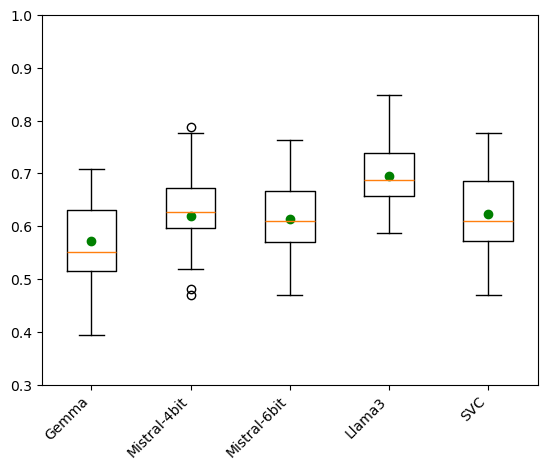

gemma_mean_time = 5.447181233855467
mistral4b_mean_time = 4.8781057735641635
mistral6b_mean_time = 13.81784514976641
llama_mean_time = 15.48073921956582
svc_mean_time = 0.001060590821654307
normal_mean_results =  [0.5715856004396812, 0.6202253366309426, 0.6133553173948887, 0.6952459466886507, 0.6237977466336906]


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_my_data(dataset_test_results, normal_mean_results, labels, y_lim_bottom = 0.0):
    fig, ax = plt.subplots()
    ax.axes.get_xaxis().set_visible(False)
    x_positions = np.arange(1, len(labels) + 1)  # Numeric positions for box plots
    ax.boxplot(dataset_test_results, positions=x_positions, labels=labels)
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    plt.ylim(y_lim_bottom, 1.0)
    
    print(x_positions)
    # Line Plot (Secondary Axis)
    #ax1 = ax.twinx()  # Create secondary y-axis
    ax1 = ax
    ax1.scatter(x_positions, normal_mean_results, color='green', marker='o', label="Mean Value")  # Scatter instead of line
    
    plt.show()

##
# This function will create a box plot for a hybridized data set (HYBRID_AT_12 or HYBRID_AT_18)
##
def testRoomClassifierAccuracy(llm_type):
    (llm_accuracies, svc_accuracies, llm_mean_time, svc_mean_time) = process_scene_files(llm_type)
    # should be two volumes -- one for LLM and one for SVC for accuracies compared to ground truth.
    number_of_dataset_volumes = 2

    # How many rooms were classified
    number_of_tests_per_dataset_volume = len(llm_accuracies)

    # We'll create an empty Numpy array and put the our SVC accuracies into there.
    dataset_test_results = np.zeros(shape=(number_of_dataset_volumes, number_of_tests_per_dataset_volume))
    #print(dataset_test_results.shape)

    dataset_test_results[0] = llm_accuracies
    dataset_test_results[1] = svc_accuracies

    # transpose it because I imagined it differently to how matplotlib needs the data
    dataset_test_results = np.transpose(dataset_test_results)
    #print(dataset_test_results)
    fig, ax = plt.subplots()
    ax.axes.get_xaxis().set_visible(False)
    ax.boxplot(dataset_test_results)
    plt.ylim(0.3, 1.0)
    plt.show()

#testRoomClassifierAccuracy("gemma")
#testRoomClassifierAccuracy("mistral")

##
# This function will create a box plot for a hybridized data set (HYBRID_AT_12 or HYBRID_AT_18)
##
def testAllRoomClassifiersAccuracy():
    (gemma_accuracies, svc_accuracies, gemma_mean_time, svc_mean_time, normal_mean_accuracies_gemma) = process_scene_files(LLMType.GEMMA)
    (mistral4b_accuracies, svc_accuracies, mistral4b_mean_time, svc_mean_time, normal_mean_accuracies_mistral4b) = process_scene_files(LLMType.MISTRAL_4b)
    (mistral6b_accuracies, svc_accuracies, mistral6b_mean_time, svc_mean_time, normal_mean_accuracies_mistral6b) = process_scene_files(LLMType.MISTRAL_6b)
    (llama_accuracies, svc_accuracies, llama_mean_time, svc_mean_time, normal_mean_accuracies_llama) = process_scene_files(LLMType.LLAMA)
    # should be two volumes -- one for LLM and one for SVC for accuracies compared to ground truth.
    number_of_dataset_volumes = 5

    # How many rooms were classified
    number_of_tests_per_dataset_volume = len(svc_accuracies)

    # We'll create an empty Numpy array and put the our SVC accuracies into there.
    dataset_test_results = np.zeros(shape=(number_of_dataset_volumes, number_of_tests_per_dataset_volume))
    #print(dataset_test_results.shape)

    dataset_test_results[0] = gemma_accuracies
    dataset_test_results[1] = mistral4b_accuracies
    dataset_test_results[2] = mistral6b_accuracies
    dataset_test_results[3] = llama_accuracies
    dataset_test_results[4] = svc_accuracies

    # transpose it because I imagined it differently to how matplotlib needs the data
    dataset_test_results = np.transpose(dataset_test_results)

    normal_mean_results = [normal_mean_accuracies_gemma[0], normal_mean_accuracies_mistral4b[0], normal_mean_accuracies_mistral6b[0], normal_mean_accuracies_llama[0], normal_mean_accuracies_llama[1]]
    labels=['Gemma', 'Mistral-4bit', 'Mistral-6bit', 'Llama3', 'SVC']
    plot_my_data(dataset_test_results, normal_mean_results, labels, 0.3)
    
    print("gemma_mean_time = " + str(gemma_mean_time))
    print("mistral4b_mean_time = " + str(mistral4b_mean_time))
    print("mistral6b_mean_time = " + str(mistral6b_mean_time))
    print("llama_mean_time = " + str(llama_mean_time))
    print("svc_mean_time = " + str(svc_mean_time))
    print("normal_mean_results = ", normal_mean_results)

testAllRoomClassifiersAccuracy()

In [36]:
from ae_gemma_llm import GemmaLLMControl
from room_type import RoomType
from scene_description import ClassifierType

glc = GemmaLLMControl()

def getAllVisibleObjectNamesInThisRoom(scene, classifier_type, rt):
  points = scene.get_all_points_of_room_type(classifier_type, rt)
  ret_set = set()
  for p in points:
      ret_set = ret_set.union(p["visible_object_names"])

  return ret_set

def process_scene_files(llm_type):
    pkl_store = "experiment_data/pkl_" + llm_type + "/scene_descr_train_*.pkl"    
    scene_files = glob.glob(pkl_store) # files showing gemma scenes
    
    for scene_f in scene_files:
        f = open(scene_f,'rb')
        scene = pickle.load(f)
        #obj_names = scene.getAllVisibleObjectNamesInThisRoom(ClassifierType.LLM, RoomType.KITCHEN)
        #points = scene.get_all_points_of_room_type(ClassifierType.LLM, RoomType.KITCHEN)
        print(getAllVisibleObjectNamesInThisRoom(scene, ClassifierType.LLM, RoomType.KITCHEN))
        
#        for p in points:
            #print(p)
#            print(p["visible_object_names"])
        #print("KITCHEN: " + str(obj_names))
        #glc.construct_object_selector_question_ranking("fresh bottle of beer", )
        
#    new_point = {
#        "point_pose" : point_pose,
#        "room_type_llm" : room_type_llm,
#        "room_type_svc" : room_type_svc,
#        "room_type_gt" : room_type_gt,
#        "visible_objects_at_this_point" : visible_objects_at_this_point,
#        "visible_object_names" : set(),
#        "elapsed_time_llm": elapsed_time_llm,
#        "elapsed_time_svc": elapsed_time_svc
#    }
        f.close()

process_scene_files("llama")

{'ButterKnife', 'Wall', 'CreditCard', 'Bread', 'Vase', 'Pen', 'Toaster', 'Drawer', 'Stool', 'Shelf', 'ShelvingUnit', 'SaltShaker', 'Floor', 'GarbageCan', 'Chair', 'CoffeeMachine', 'Window', 'CounterTop', 'Fridge', 'DishSponge', 'SideTable', 'HousePlant', 'Doorway', 'Bowl', 'DeskLamp', 'Mug', 'Pot', 'DiningTable'}
{'Wall', 'Box', 'Faucet', 'Sink', 'Doorway', 'BasketBall', 'Painting', 'SinkBasin', 'GarbageCan'}
{'Wall', 'Bread', 'Fork', 'Vase', 'Potato', 'Tomato', 'SoapBottle', 'Safe', 'Doorframe', 'SaltShaker', 'Floor', 'Cart', 'Window', 'CounterTop', 'Fridge', 'Pencil', 'Doorway', 'Painting', 'HousePlant', 'DiningTable', 'Laptop'}
{'Candle', 'GarbageBag', 'Vase', 'Egg', 'CoffeeMachine', 'Window', 'CellPhone', 'Faucet', 'WineBottle', 'Painting', 'HousePlant', 'DiningTable', 'Cup', 'SprayBottle', 'Wall', 'Fork', 'Tomato', 'RemoteControl', 'Sink', 'KeyChain', 'Floor', 'Bottle', 'GarbageCan', 'Cart', 'Chair', 'CounterTop', 'Pan', 'Fridge', 'Doorway', 'Apple', 'Book', 'Bowl', 'SinkBasin', '

In [4]:
from ae_llm import LLMControl, LLMType

lc = LLMControl(LLMType.MISTRAL_6b)

lc.construct_object_selector_question_ranking("fresh bottle of beer", {'SprayBottle', 'Shelf', 'Wall', 'BaseballBat', 'Bowl', 'HousePlant', 'Doorway', 'Plate', 'Vase', 'Potato', 'Toaster', 'ArmChair', 'Painting', 'Window', 'Apple', 'CounterTop', 'Chair', 'Pencil', 'DiningTable', 'Cart', 'Floor', 'GarbageBag', 'Fridge', 'ShelvingUnit', 'Drawer', 'WineBottle'})
lc.get_object_selector_answer()

3
 LLM :mistral:7b-instruct-v0.2-q6_K
3
 Based on the given context, a fresh bottle of beer is most likely to be found near a Fridge. The reason for this is that refrigerators are commonly used to store beer, as the cool temperature helps preserve the carbonation and freshness of the beer. Therefore, a fresh bottle of beer would typically be found in or nearby a fridge.

Ranking of objects from most likely to least likely to be near a fresh bottle of beer:
1. Fridge
2. Shelving Unit (for storing beer bottles)
3. CounterTop (where one might open and pour the beer)
4. Table (such as a dining table or coffee table, where one might drink the beer)
5. Floor (if the bottle was accidentally dropped)
6. Cart (used to transport heavy items such as cases of beer)
7. Wall (as in a beer tap wall or beer fridge built into a wall)
8. SprayBottle (unrelated)
9. Vase (unrelated)
10. HousePlant (unrelated)
11. Shelf (while beer can be stored on shelves, it is more likely to be found in a refrigerator o

In [32]:
from ae_llm import LLMControl, LLMType

lc = LLMControl(LLMType.GEMMA)

lc.initialise_for_ai2_thor_room_classification()
lc.get_answer_structured_qry()

Reasoning : Candle is commonly associated with a bedroom setting , while a plunger and scrub brush are typically used for cleaning bathrooms. Therefore I would guess that the room is a bedroom.
Answer : 3

In [89]:
from ae_llm import LLMControl, LLMType
from time import time

lc = LLMControl(LLMType.GEMMA)

t0 = time() 
lc.construct_classifier_question({'CounterTop', 'HousePlant', 'SideTable', 'Wall'})
lc.get_answer()
print(str(time() - t0))

t0 = time() 
lc.construct_classifier_question({'Doorway', 'Wall', 'Fridge'})
lc.get_answer()
print(str(time() - t0))


lc = LLMControl(LLMType.LLAMA)

t0 = time() 
lc.construct_classifier_question({'CellPhone', 'KeyChain', 'HousePlant', 'Floor', 'DeskLamp', 'ArmChair', 'DiningTable', 'Laptop'})
lc.get_answer()
print(str(time() - t0))

t0 = time() 
lc.construct_classifier_question({'Pillow', 'Bed', 'Wall'})
lc.get_answer()
print(str(time() - t0))

**2. Kitchen**

The presence of a 'CounterTop' and 'SideTable' is commonly found in kitchens. Additionally, the presence of a 'HousePlant' is also common in kitchens as they are often used to add aesthetic appeal to the room.17.70012068748474
**2. Kitchen**

The presence of a Fridge in the room suggests that it is a kitchen. Fridges are commonly found in kitchens and are used to store perishable food items.13.96256971359253
I would choose option 3, Bedroom.

Here's my reasoning:

* A 'DiningTable' and a 'Laptop' are not typically found in a bathroom or kitchen.
* A 'HousePlant' is often kept as a decorative item in a bedroom or living room.
* An 'ArmChair' is a common piece of furniture in a bedroom, whereas it might be more likely to find a sofa in a living room.
* A 'KeyChain' and a 'CellPhone' are both personal items that are commonly found in a bedroom or bag/pocket.

Overall, the presence of these objects suggests that this is a private space where someone lives and works, which i